In [29]:
import os
import matplotlib.pyplot as plt
import random
import numpy as np
import numpy
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.datasets import cifar10
from keras.layers import Add, Dense, Activation, BatchNormalization, Conv2D
from keras.layers import Flatten
from keras.layers.convolutional import MaxPooling2D
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow_datasets as tfds
import tensorflow as tf
from keras.utils import np_utils
from keras.initializers import glorot_uniform
%matplotlib inline

In [30]:
model_type = 'vgg16'

In [31]:
model_home_dir = os.path.join(os.getcwd(), 'CNN_TASK_ODED',"model_type")
print(model_home_dir)
if not os.path.isdir(model_home_dir):
    print('Inside mkdir')
    os.makedirs(model_home_dir)

/home/ec2-user/SageMaker/Research/AWS/CNN_TASK_ODED/model_type


In [32]:
#Defining Variables

#Data set information
DATASET = 'cifar-10'
num_classes = 2
input_shape=(32,32,3)
epochs = 200
lrate = 0.01
decay = lrate/epochs
batch_size = 32
seed = 7
np.random.seed(seed)

validate_dir = os.path.join("data","test")
train_dir = os.path.join("data","train")

# Prepare model model saving directory.
save_dir = os.path.join(model_home_dir, 'saved_models')

model_name = DATASET+'_'+'%s_model.{epoch:03d}.h5' % model_type

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
print("Model Type: ",model_type)
print("Model File: ",filepath)

Model Type:  vgg16
Model File:  /home/ec2-user/SageMaker/Research/AWS/CNN_TASK_ODED/model_type/saved_models/cifar-10_vgg16_model.{epoch:03d}.h5


In [33]:
def preprocess(img, label):
    return tf.image.resize(img, [HEIGHT, WIDTH]) / 255, label

HEIGHT = 32
WIDTH = 32
split = ['train[:85%]', 'train[85%:]']


trainDataset, testDataset = tfds.load('cats_vs_dogs',
                         split = split,
                         batch_size=1, 
                         as_supervised=True)



trainDataset = trainDataset.map(preprocess)
testDataset = testDataset.map(preprocess)

train = list(tfds.as_numpy(trainDataset))
test = list(tfds.as_numpy(testDataset))

X_train = [e[0][0].astype('float32') for e in train]
X_test = [e[0][0].astype('float32') for e in test]

X_train = numpy.stack(X_train)
X_test = numpy.stack(X_test)

y_train = [e[1][0] for e in train]
y_test = [e[1][0] for e in test]

y_train = numpy.stack(y_train).reshape((-1,1)) 
y_test = numpy.stack(y_test).reshape((-1,1)) 

print(y_train.shape, y_test.shape)
print(X_train.shape, X_test.shape)

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


(19773, 1) (3489, 1)
(19773, 32, 32, 3) (3489, 32, 32, 3)


------------------concatenate train-------------------


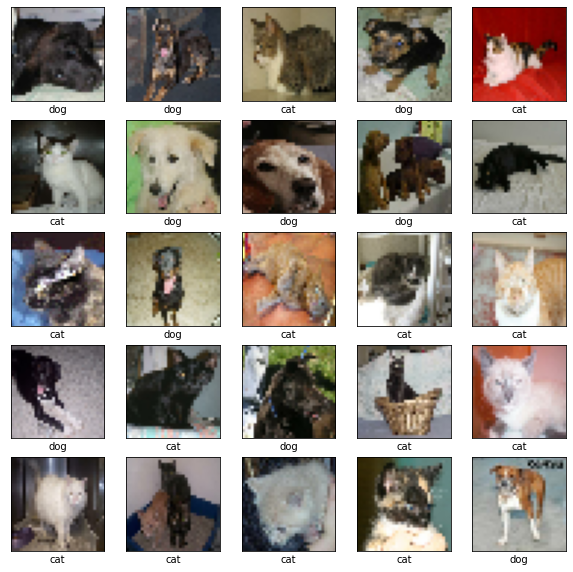

------------------concatenate test-------------------


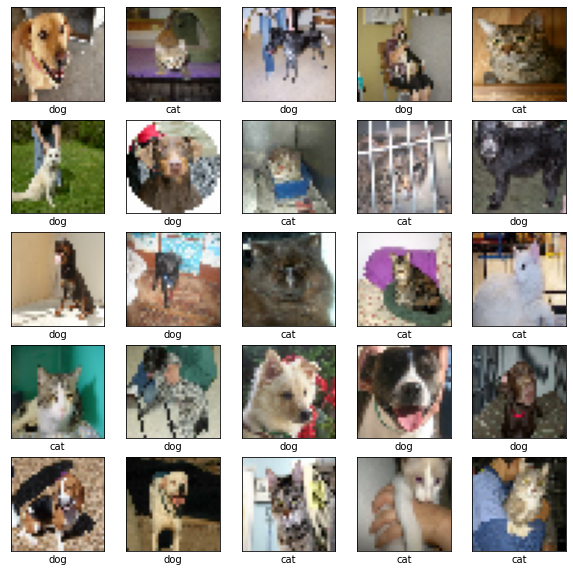

In [34]:
class_names = ['cat', 'dog']

print("------------------concatenate train-------------------")
plt.figure(figsize=(10,10))
for i in range(25):
    j = random.randint(0,19773)
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[j])
    plt.xlabel(class_names[y_train[j][0]])
plt.show()

print("------------------concatenate test-------------------")
plt.figure(figsize=(10,10))
for i in range(25):
    j = random.randint(0,3489) 
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[j])
    plt.xlabel(class_names[y_test[j][0]])
plt.show()

In [35]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')


X_train_mean = np.mean(X_train)
X_train -= X_train_mean
X_test_mean = np.mean(X_test)
X_test -= X_test_mean

y_train = np_utils.to_categorical(y_train,)
y_test = np_utils.to_categorical(y_test,)
y_train = np.delete(y_train,1,1)
y_test = np.delete(y_test,1,1)
print(y_train.shape, y_test.shape)



(19773, 1) (3489, 1)


In [36]:
from tensorflow.keras.layers import Dropout
def vgg16(input_shape=(32,32,3), num_classes=2):
  model = Sequential()
  model.add(Conv2D(input_shape=input_shape,filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))


  model.add(Dropout(0.8))

  model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  # model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  # model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  # model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  model.add(Flatten())
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=1, activation="sigmoid"))

  return model

In [37]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


In [38]:
# Prepare callbacks for model saving and for learning rate adjustment.

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler,early_stopping]


In [39]:
import keras
model = vgg16(input_shape,num_classes)

# Compile model

# optimizer = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer=optimizer,
              loss=keras.losses.BinaryCrossentropy(label_smoothing = 0.05),
              metrics=[keras.metrics.BinaryAccuracy()])

print("Model Summary of ",model_type)
print(model.summary())



Model Summary of  vgg16
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 16)        9232      
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 16)        2320      
                              

/home/ec2-user/anaconda3/envs/tensorflow2_p38/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [40]:
# Score trained model.
history = model.fit(X_train, y_train,
      batch_size=batch_size,
      epochs=epochs,
      validation_data=(X_test, y_test),
      shuffle=True,
      callbacks=callbacks)
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Learning rate:  0.001
Epoch 1/200
610/618 [============================>.] - ETA: 0s - loss: 0.6526 - binary_accuracy: 0.6192WARNING:tensorflow:Can save best model only with val_acc available, skipping.


618/618 [==============================] - 4s 6ms/step - loss: 0.6518 - binary_accuracy: 0.6204 - val_loss: 0.6220 - val_binary_accuracy: 0.6655 - lr: 0.0010
Learning rate:  0.001
Epoch 2/200
611/618 [============================>.] - ETA: 0s - loss: 0.5946 - binary_accuracy: 0.6947WARNING:tensorflow:Can save best model only with val_acc available, skipping.


618/618 [==============================] - 3s 6ms/step - loss: 0.5947 - binary_accuracy: 0.6947 - val_loss: 0.5819 - val_binary_accuracy: 0.7177 - lr: 0.0010
Learning rate:  0.001
Epoch 3/200
610/618 [============================>.] - ETA: 0s - loss: 0.5608 - binary_accuracy: 0.7237WARNING:tensorflow:Can save best model only with val_acc available, skipping.


618/618 [==============================] - 3s 6ms/step - loss: 0.5605 - binary_accuracy: 0.7241 - val_loss: 0.5336 - val_binary_accuracy: 0.7443 - lr: 0.0010
Learning rate:  0.001
Epoch 4/200
609/618 [============================>.] - ETA: 0s - loss: 0.5350 - binary_accuracy: 0.7439WARNING:tensorflow:Can save best model only with val_acc available, skipping.


618/618 [==============================] - 3s 6ms/step - loss: 0.5353 - binary_accuracy: 0.7436 - val_loss: 0.5126 - val_binary_accuracy: 0.7655 - lr: 0.0010
Learning rate:  0.001
Epoch 5/200
611/618 [============================>.] - ETA: 0s - loss: 0.5134 - binary_accuracy: 0.7651WARNING:tensorflow:Can save best model only with val_acc available, skipping.


618/618 [==============================] - 3s 6ms/step - loss: 0.5135 - binary_accuracy: 0.7652 - val_loss: 0.4934 - val_binary_accuracy: 0.7865 - lr: 0.0010
Learning rate:  0.001
Epoch 6/200
611/618 [============================>.] - ETA: 0s - loss: 0.5002 - binary_accuracy: 0.7742WARNING:tensorflow:Can save best model only with val_acc available, skipping.


618/618 [==============================] - 3s 6ms/step - loss: 0.4992 - binary_accuracy: 0.7750 - val_loss: 0.4756 - val_binary_accuracy: 0.7888 - lr: 0.0010
Learning rate:  0.001
Epoch 7/200
611/618 [============================>.] - ETA: 0s - loss: 0.4847 - binary_accuracy: 0.7865WARNING:tensorflow:Can save best model only with val_acc available, skipping.


618/618 [==============================] - 3s 6ms/step - loss: 0.4847 - binary_accuracy: 0.7864 - val_loss: 0.4881 - val_binary_accuracy: 0.7836 - lr: 0.0010
Learning rate:  0.001
Epoch 8/200
610/618 [============================>.] - ETA: 0s - loss: 0.4759 - binary_accuracy: 0.7927WARNING:tensorflow:Can save best model only with val_acc available, skipping.


618/618 [==============================] - 3s 6ms/step - loss: 0.4760 - binary_accuracy: 0.7927 - val_loss: 0.4587 - val_binary_accuracy: 0.8060 - lr: 0.0010
Learning rate:  0.001
Epoch 9/200
611/618 [============================>.] - ETA: 0s - loss: 0.4672 - binary_accuracy: 0.7986WARNING:tensorflow:Can save best model only with val_acc available, skipping.


618/618 [==============================] - 3s 6ms/step - loss: 0.4670 - binary_accuracy: 0.7986 - val_loss: 0.4487 - val_binary_accuracy: 0.8114 - lr: 0.0010
Learning rate:  0.001
Epoch 10/200
618/618 [==============================] - ETA: 0s - loss: 0.4511 - binary_accuracy: 0.8066WARNING:tensorflow:Can save best model only with val_acc available, skipping.


618/618 [==============================] - 3s 6ms/step - loss: 0.4511 - binary_accuracy: 0.8066 - val_loss: 0.4563 - val_binary_accuracy: 0.7942 - lr: 0.0010
Learning rate:  0.001
Epoch 11/200
610/618 [============================>.] - ETA: 0s - loss: 0.4446 - binary_accuracy: 0.8118WARNING:tensorflow:Can save best model only with val_acc available, skipping.


618/618 [==============================] - 3s 6ms/step - loss: 0.4444 - binary_accuracy: 0.8118 - val_loss: 0.4448 - val_binary_accuracy: 0.8071 - lr: 0.0010
Learning rate:  0.001
Epoch 12/200
611/618 [============================>.] - ETA: 0s - loss: 0.4367 - binary_accuracy: 0.8191WARNING:tensorflow:Can save best model only with val_acc available, skipping.


618/618 [==============================] - 3s 6ms/step - loss: 0.4372 - binary_accuracy: 0.8186 - val_loss: 0.4543 - val_binary_accuracy: 0.8062 - lr: 0.0010
Learning rate:  0.001
Epoch 13/200
610/618 [============================>.] - ETA: 0s - loss: 0.4246 - binary_accuracy: 0.8239WARNING:tensorflow:Can save best model only with val_acc available, skipping.


618/618 [==============================] - 3s 6ms/step - loss: 0.4243 - binary_accuracy: 0.8240 - val_loss: 0.4421 - val_binary_accuracy: 0.8143 - lr: 0.0010
Learning rate:  0.001
Epoch 14/200
609/618 [============================>.] - ETA: 0s - loss: 0.4128 - binary_accuracy: 0.8355WARNING:tensorflow:Can save best model only with val_acc available, skipping.


618/618 [==============================] - 3s 6ms/step - loss: 0.4133 - binary_accuracy: 0.8353 - val_loss: 0.4448 - val_binary_accuracy: 0.8045 - lr: 0.0010
Learning rate:  0.001
Epoch 15/200
610/618 [============================>.] - ETA: 0s - loss: 0.3990 - binary_accuracy: 0.8418WARNING:tensorflow:Can save best model only with val_acc available, skipping.


618/618 [==============================] - 3s 6ms/step - loss: 0.3995 - binary_accuracy: 0.8414 - val_loss: 0.4416 - val_binary_accuracy: 0.8105 - lr: 0.0010
Learning rate:  0.001
Epoch 16/200
610/618 [============================>.] - ETA: 0s - loss: 0.3879 - binary_accuracy: 0.8507WARNING:tensorflow:Can save best model only with val_acc available, skipping.


618/618 [==============================] - 3s 6ms/step - loss: 0.3880 - binary_accuracy: 0.8507 - val_loss: 0.4435 - val_binary_accuracy: 0.8269 - lr: 0.0010
Learning rate:  0.001
Epoch 17/200
611/618 [============================>.] - ETA: 0s - loss: 0.3760 - binary_accuracy: 0.8576WARNING:tensorflow:Can save best model only with val_acc available, skipping.


618/618 [==============================] - 3s 6ms/step - loss: 0.3754 - binary_accuracy: 0.8581 - val_loss: 0.4329 - val_binary_accuracy: 0.8234 - lr: 0.0010
Learning rate:  0.001
Epoch 18/200
610/618 [============================>.] - ETA: 0s - loss: 0.3637 - binary_accuracy: 0.8643WARNING:tensorflow:Can save best model only with val_acc available, skipping.


618/618 [==============================] - 3s 6ms/step - loss: 0.3634 - binary_accuracy: 0.8646 - val_loss: 0.4438 - val_binary_accuracy: 0.8148 - lr: 0.0010
Learning rate:  0.001
Epoch 19/200
611/618 [============================>.] - ETA: 0s - loss: 0.3494 - binary_accuracy: 0.8727WARNING:tensorflow:Can save best model only with val_acc available, skipping.


618/618 [==============================] - 3s 6ms/step - loss: 0.3491 - binary_accuracy: 0.8729 - val_loss: 0.4797 - val_binary_accuracy: 0.8034 - lr: 0.0010
Learning rate:  0.001
Epoch 20/200
610/618 [============================>.] - ETA: 0s - loss: 0.3359 - binary_accuracy: 0.8835WARNING:tensorflow:Can save best model only with val_acc available, skipping.


618/618 [==============================] - 3s 6ms/step - loss: 0.3362 - binary_accuracy: 0.8832 - val_loss: 0.4606 - val_binary_accuracy: 0.8160 - lr: 0.0010
Learning rate:  0.001
Epoch 21/200
611/618 [============================>.] - ETA: 0s - loss: 0.3146 - binary_accuracy: 0.8945WARNING:tensorflow:Can save best model only with val_acc available, skipping.


618/618 [==============================] - 3s 6ms/step - loss: 0.3146 - binary_accuracy: 0.8946 - val_loss: 0.4839 - val_binary_accuracy: 0.8071 - lr: 0.0010
Learning rate:  0.001
Epoch 22/200
611/618 [============================>.] - ETA: 0s - loss: 0.2998 - binary_accuracy: 0.9055WARNING:tensorflow:Can save best model only with val_acc available, skipping.


110/110 [==============================] - 0s 2ms/step - loss: 0.4329 - binary_accuracy: 0.8234
Test loss: 0.43291181325912476
Test accuracy: 0.8234451413154602


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy', 'lr'])


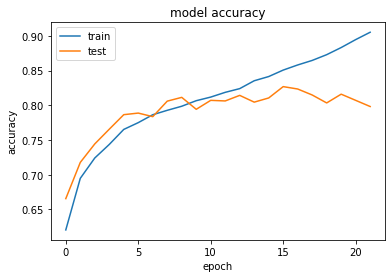

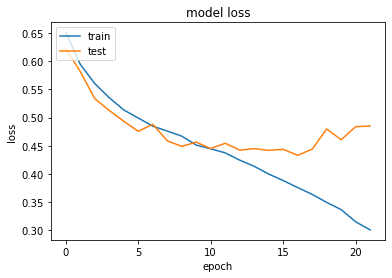

In [41]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

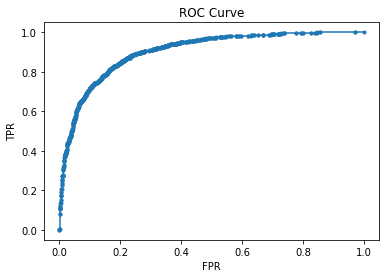

0.9033753138680374


In [42]:
from sklearn.metrics import roc_curve, auc

y_pred = model.predict(X_test).ravel()

nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(nn_fpr_keras, nn_tpr_keras)
plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras)
plt.title('ROC Curve')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

print(auc_keras)

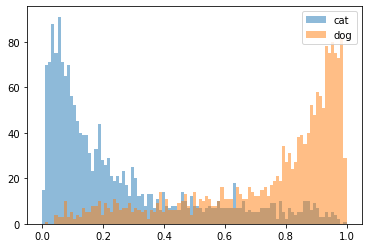

In [43]:
from matplotlib import pyplot
predict_x=model.predict(X_test) 

cat_index = np.where(y_test.reshape(-1) == 0.)
cat = predict_x[cat_index]

dog_index = np.where(y_test.reshape(-1) == 1.)
dog = predict_x[dog_index]



bins = np.linspace(0, 1, 100)

pyplot.hist(cat, bins, alpha=0.5, label='cat')
pyplot.hist(dog, bins, alpha=0.5, label='dog')
pyplot.legend(loc='upper right')
pyplot.show()

In [44]:
len(dog)

1720

In [45]:
len(cat)

1769